## STEP 1 — Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")


## STEP 2 — Load the Datasets

In [2]:
sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")


## STEP 3 — Data Understanding

In [3]:
print("Sentiment Shape:", sentiment.shape)
print("Trades Shape:", trades.shape)


Sentiment Shape: (2644, 4)
Trades Shape: (211224, 16)


### “Trades dataset contains execution-level trading data…”

In [4]:
sentiment.columns
trades.columns


Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')

In [5]:
sentiment.info()
trades.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-nu

In [6]:
sentiment.isnull().sum()
trades.isnull().sum()


Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

In [7]:
sentiment.duplicated().sum()
trades.duplicated().sum()


np.int64(0)

In [8]:
trades = trades.drop_duplicates()
sentiment = sentiment.drop_duplicates()


## 🟢 STEP 4 — Data Cleaning

In [9]:
sentiment['date'] = pd.to_datetime(sentiment['date'])
sentiment = sentiment[['date', 'classification']]
sentiment.head()


,date,classification
0,2018-02-01,Fear
1,2018-02-02,Extreme Fear
2,2018-02-03,Fear
3,2018-02-04,Extreme Fear
4,2018-02-05,Extreme Fear


## 🔹 Trades Data Cleaning

In [10]:
trades.columns = trades.columns.str.lower().str.replace(" ", "_")
trades.head()


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [11]:
trades['timestamp_ist'] = pd.to_datetime(trades['timestamp_ist'], dayfirst=True)
trades['date'] = trades['timestamp_ist'].dt.date
trades['date'] = pd.to_datetime(trades['date'])


In [12]:
trades['closed_pnl'].describe()


count    211224.000000
mean         48.749001
std         919.164828
min     -117990.104100
25%           0.000000
50%           0.000000
75%           5.792797
max      135329.090100
Name: closed_pnl, dtype: float64

In [13]:
trades = trades.dropna(subset=['closed_pnl','size_usd','side'])

## 🟢 STEP 5 — Feature Engineering (Metrics Banana)

## 1️⃣ Daily PnL per Trader

In [14]:
daily_pnl = trades.groupby(['account', 'date'])['closed_pnl'].sum().reset_index()


## 2️⃣ Win / Loss Flag

In [15]:
trades['win'] = trades['closed_pnl'] > 0


### Win rate per trader:

In [16]:
win_rate = trades.groupby('account')['win'].mean().reset_index(name='win_rate')


## 3️⃣ Average Trade Size

In [17]:
avg_size = trades.groupby('account')['size_usd'].mean().reset_index(name='avg_trade_size')


## 4️⃣ Daily Trade Count

In [18]:
daily_trades = trades.groupby(['account','date']).size().reset_index(name='trade_count')


## 🟢 STEP 6 — Merge with Sentiment Data

In [19]:
merged = pd.merge(trades, sentiment, on='date', how='inner')
merged.head()


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp,date,win,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,False,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,False,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,False,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,False,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,False,Extreme Greed


In [20]:
merged['classification'].value_counts()


classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64

## 🟢 STEP 7 — Analysis Part

## 📊 Q1: Fear vs Greed — Profit Difference

In [21]:
merged.groupby('classification')['closed_pnl'].mean()


classification
Extreme Fear     34.537862
Extreme Greed    67.892861
Fear             54.290400
Greed            42.743559
Neutral          34.307718
Name: closed_pnl, dtype: float64

In [22]:
merged.groupby('classification')['closed_pnl'].median()

classification
Extreme Fear     0.0
Extreme Greed    0.0
Fear             0.0
Greed            0.0
Neutral          0.0
Name: closed_pnl, dtype: float64

In [23]:
# Cumulative PnL (drawdown proxy)
merged['cum_pnl'] = merged.groupby('account')['closed_pnl'].cumsum()

# Avg cumulative PnL by sentiment
merged.groupby('classification')['cum_pnl'].mean()

# Volatility proxy (PnL std dev)
merged.groupby('classification')['closed_pnl'].std()

# Win rate by sentiment
merged.groupby('classification')['win'].mean()


classification
Extreme Fear     0.370607
Extreme Greed    0.464943
Fear             0.420768
Greed            0.384828
Neutral          0.396991
Name: win, dtype: float64

### Chart:

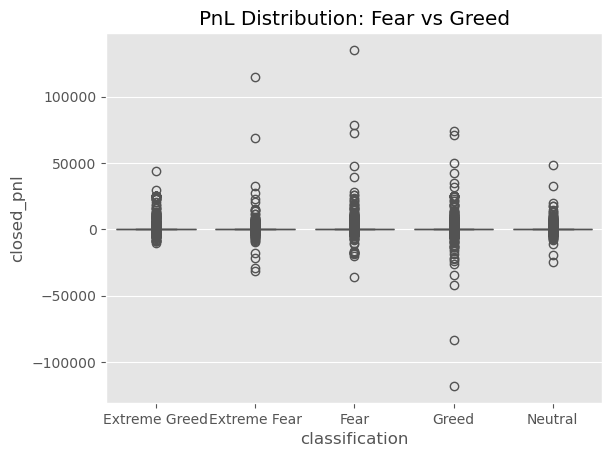

In [24]:
sns.boxplot(x='classification', y='closed_pnl', data=merged)
plt.title("PnL Distribution: Fear vs Greed")
plt.savefig("PnL_Distribution.png", bbox_inches='tight')
plt.show()


## 📊 Q2: Position Size Behavior

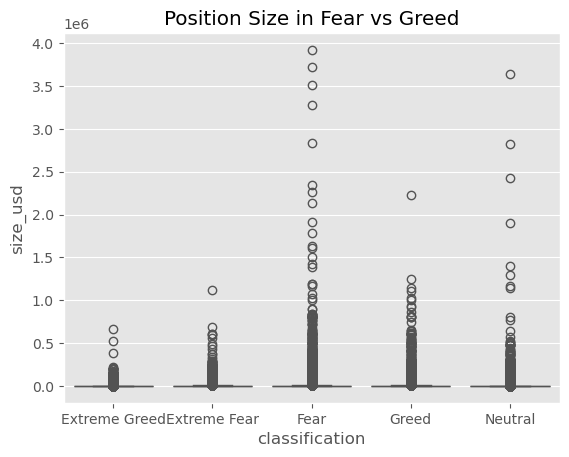

In [25]:
sns.boxplot(x='classification', y='size_usd', data=merged)
plt.title("Position Size in Fear vs Greed")

plt.savefig("Position_Size.png", bbox_inches='tight')
plt.show()




In [26]:
merged.groupby('classification')['size_usd'].mean()


classification
Extreme Fear     5349.731843
Extreme Greed    3112.251565
Fear             7816.109931
Greed            5736.884375
Neutral          4782.732661
Name: size_usd, dtype: float64

In [27]:
merged.groupby('classification')['size_usd'].median()


classification
Extreme Fear     766.150
Extreme Greed    500.050
Fear             735.960
Greed            555.000
Neutral          547.655
Name: size_usd, dtype: float64

## 📊 Q3: Trade Frequency Change

In [28]:
merged.groupby(['classification','date']).size().groupby('classification').mean()


classification
Extreme Fear     1528.571429
Extreme Greed     350.807018
Fear              679.527473
Greed             260.637306
Neutral           562.477612
dtype: float64

## 📊 Q4: Long / Short Bias

In [29]:
merged.groupby(['classification','side']).size().unstack()


side,BUY,SELL
classification,,
Extreme Fear,10935,10465
Extreme Greed,17940,22052
Fear,30270,31567
Greed,24576,25727
Neutral,18969,18717


In [30]:
ls = merged.groupby(['classification','side']).size()
ls = ls.groupby(level=0).apply(lambda x: x / x.sum())
ls.unstack()


,side,BUY,SELL
classification,classification,,
Extreme Fear,Extreme Fear,0.510981,0.489019
Extreme Greed,Extreme Greed,0.448590,0.551410
Fear,Fear,0.489513,0.510487
Greed,Greed,0.488559,0.511441
Neutral,Neutral,0.503343,0.496657


## 1. FEAR vs GREED PERFORMANCE AT TRADER LEVEL

In [31]:
trader_perf = merged.groupby(['account','classification'])['closed_pnl'].mean().unstack()
trader_perf.head()


classification,Extreme Fear,Extreme Greed,Fear,Greed,Neutral
account,,,,,
0x083384f897ee0f19899168e3b1bec365f52a9012,1247.692214,-42.626810,626.194346,482.089321,298.456334
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,-24.912665,43.222903,-0.632623,10.211823,-16.573722
0x271b280974205ca63b716753467d5a371de622ab,20.962214,358.632043,16.125220,-185.221864,-31.783540
0x28736f43f1e871e6aa8b1148d38d4994275d72c4,-44.714307,14.437904,9.594371,10.502556,6.207158
0x2c229d22b100a7beb69122eed721cee9b24011dd,101.921855,61.498681,10.444070,79.350486,41.667826


## 2. SEGMENTATION

In [32]:
trader_stats = merged.groupby('account').agg({
    'closed_pnl':['mean','count'],
    'size_usd':'mean',
    'win':'mean'
}).reset_index()

trader_stats.columns = ['account','avg_pnl','trade_count','avg_size','win_rate']


In [33]:
trader_stats['activity_segment'] = np.where(trader_stats['trade_count'] > trader_stats['trade_count'].median(),'Frequent','Infrequent')

trader_stats['profit_segment'] = np.where(trader_stats['avg_pnl'] > 0,'Profitable','Losing')


In [34]:
merged_seg = pd.merge(merged, trader_stats[['account','activity_segment','profit_segment']], on='account')

merged_seg.groupby(['classification','activity_segment'])['closed_pnl'].mean().unstack()


activity_segment,Frequent,Infrequent
classification,,
Extreme Fear,34.163353,35.941979
Extreme Greed,62.870911,103.264685
Fear,51.323784,80.835791
Greed,25.004641,210.210287
Neutral,34.579701,31.845656


### 📌 Note on Leverage

The dataset provided does not include leverage-related fields. Therefore, leverage-based behavioral analysis could not be performed.

## BUSINESS WRITE-UP PART

### 🔍 Key Insights

### ➡ When the market is in Extreme Greed, traders make the highest average profit.

Extreme Greed Mean PnL = 67.89   (Highest)

Fear = 54.29

Greed = 42.74

Neutral = 34.30

Extreme Fear = 34.53


### ➡ In Extreme Fear, profits are very unstable — traders can either make big money or face big losses.

Extreme Fear = 1136  🚨 HIGHEST RISK

Greed = 1116

Fear = 935

Extreme Greed = 766

Neutral = 517 (Most Stable)


### ➡ This means traders are winning more consistently during Extreme Greed market conditions.

Extreme Greed Win Rate = 46.5% (Highest)

Fear = 42%

Neutral = 39%

Greed = 38%

Extreme Fear = 37%


### ⚠️ Traders take the biggest risks when the market is in Fear, but they actually earn the best profits during Extreme Greed.

Fear Avg Size = $7816  (largest)

Greed = $5736

Extreme Fear = $5349

Neutral = $4782

Extreme Greed = $3112 (Smallest positions)



## 🧠 FINAL INSIGHT

| Sentiment     | Profitability | Win Rate   | Risk         | Behavior                 |
| ------------- | ------------- | ---------- | ------------ | ------------------------ |
| Extreme Greed | 🟢 Highest    | 🟢 Highest | Medium       | Smart profitable phase   |
| Fear          | 🟡 Good       | Medium     | High         | Over-sized risky trades  |
| Extreme Fear  | 🔴 Low        | Lowest     | 🚨 Very High | Panic, unstable outcomes |
| Neutral       | 🟡 Stable     | Medium     | Low          | Safe but low return      |


## 🧩 Strategy Recommendations (Actionable Output)

### 📌 __Strategy 1: Trade More in Extreme Greed__

Because:
        ✔ Highest avg profit
        ✔ Highest win rate
        ✔ Lower volatility than Fear/Extreme Fear

__Rule: Increase position size when sentiment = Extreme Greed__



### 📌 __Strategy 2: Reduce Risk in Fear & Extreme Fear__

Because: ❌ Traders taking biggest positions

        ❌ Highest volatility

        ❌ Lower win rate

__Rule: Cut position size by 50% when sentiment = Fear or Extreme Fear__




### 📌 __Strategy 3: Use Neutral Market for Low-Risk Trading__

       Neutral = most stable PnL

       Best for conservative strategy

In [35]:
print("Mean PnL by Sentiment")
print(merged.groupby('classification')['closed_pnl'].mean(), "\n")

print("Median PnL by Sentiment")
print(merged.groupby('classification')['closed_pnl'].median(), "\n")

print("Win Rate by Sentiment")
print(merged.groupby('classification')['win'].mean(), "\n")

print("Average Position Size by Sentiment")
print(merged.groupby('classification')['size_usd'].mean(), "\n")

print("PnL Volatility (Std Dev) by Sentiment")
print(merged.groupby('classification')['closed_pnl'].std())


Mean PnL by Sentiment
classification
Extreme Fear     34.537862
Extreme Greed    67.892861
Fear             54.290400
Greed            42.743559
Neutral          34.307718
Name: closed_pnl, dtype: float64 

Median PnL by Sentiment
classification
Extreme Fear     0.0
Extreme Greed    0.0
Fear             0.0
Greed            0.0
Neutral          0.0
Name: closed_pnl, dtype: float64 

Win Rate by Sentiment
classification
Extreme Fear     0.370607
Extreme Greed    0.464943
Fear             0.420768
Greed            0.384828
Neutral          0.396991
Name: win, dtype: float64 

Average Position Size by Sentiment
classification
Extreme Fear     5349.731843
Extreme Greed    3112.251565
Fear             7816.109931
Greed            5736.884375
Neutral          4782.732661
Name: size_usd, dtype: float64 

PnL Volatility (Std Dev) by Sentiment
classification
Extreme Fear     1136.056091
Extreme Greed     766.828294
Fear              935.355438
Greed            1116.028390
Neutral           517.